In [1]:
# use SAM model to segment the image

import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from segment_anything import (
    SamAutomaticMaskGenerator, sam_model_registry,
    SamPredictor
)

from utils import show_mask

# !wget -O medsam_vit_b.pth https://zenodo.org/records/10689643/files/medsam_vit_b.pth
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/home/pradeep/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
dict = {}

In [4]:
# # import sys
# # sys.path.append("..")
device = "cpu"

# sam_checkpoint = "/home/pradeep/Documents/IITH_Academics/sem-6/AI in Biomedicine and Healthcare/BM5020-Project/medsam_vit_b.pth"
# model_type = "vit_b"

sam_checkpoint = "/home/pradeep/Documents/IITH_Academics/sem-6/AI in Biomedicine and Healthcare/BM5020-Project/sam_vit_h_4b8939.pth"
model_type = "vit_h"

# print(sam_checkpoint.keys())
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)


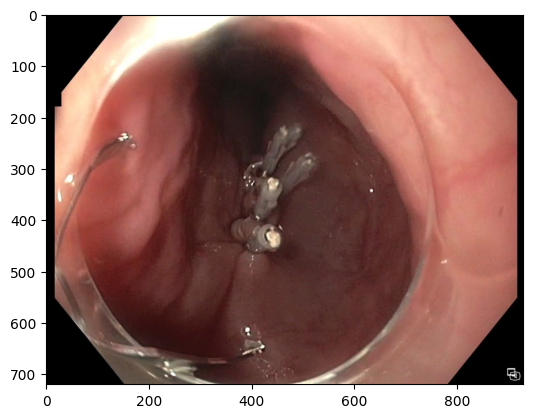

In [162]:
path = "Data/1.jpg"

image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

In [155]:
# Classes: 0 - background, 1 - muscle layer, 2 - mucoasal layer, 3 - electrode  
input_boxes = torch.tensor([
    [50, 0, 750, 720], # muscle layer
    [50, 50, 50, 50], # mucoasal layer
    [50, 150, 600, 680], # electrode
])

# image = image[:, 380:, :]
predictor.set_image(image)

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, a, b = predictor.predict_torch(
    point_coords=None,
    point_labels=torch.tensor([[0, 1], [0, 1]]),
    boxes=transformed_boxes,
    multimask_output=False,
)

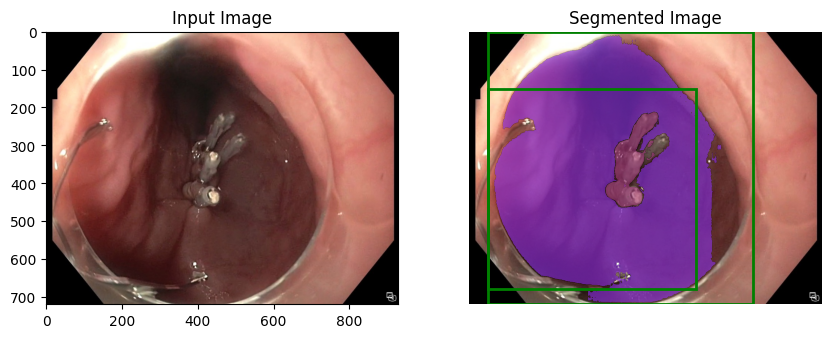

In [169]:
visualize_results(image, masks[:, :, :, :], input_boxes)

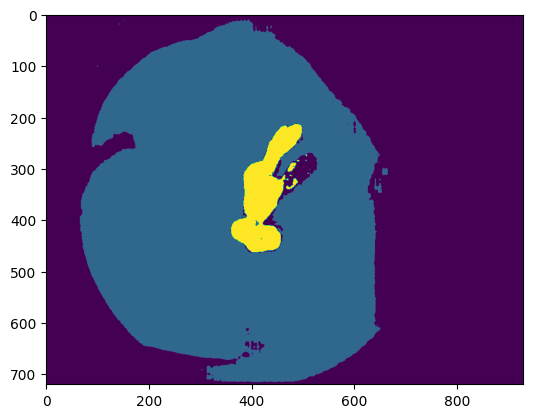

In [166]:
masks = masks + 0
mask = np.zeros(image.shape[:2], dtype=np.uint8)

mask = np.where(masks.sum(0).squeeze() > 0, masks.argmax(0).squeeze() + 1, 0)

plt.imshow(mask)

In [167]:
dict[path] = mask
print(dict.keys())

dict[path].shape

dict_keys(['Data/1.jpg', 'Data/2.jpg', 'Data/3.jpg', 'Data/4.jpg', 'Data/5.jpg', 'Data/6.jpg', 'Data/7.jpg', 'Data/8.jpg', 'Data/9.jpg', 'Data/10.jpg'])


(720, 930)

In [171]:
import pickle

with open('segmented_images.pkl', 'wb') as f:
    pickle.dump(dict, f)

with open('segmented_images.pkl', 'rb') as f:
    data = pickle.load(f)

print(data.keys())
print(data[path].shape)

dict_keys(['Data/1.jpg', 'Data/2.jpg', 'Data/3.jpg', 'Data/4.jpg', 'Data/5.jpg', 'Data/6.jpg', 'Data/7.jpg', 'Data/8.jpg', 'Data/9.jpg', 'Data/10.jpg'])
(720, 930)


In [60]:
# mask  - height, width
# mask[i][j] = index of the box that pixel i,j belongs to
# save as pickle file
# If all values are false then it is background class
# Classes: 0 - background, 1 - muscle layer, 2 - mucoasal layer, 3 - electrode  


{'Data/1.jpg': tensor([[[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]],
 
 
         [[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]],
 
 
         [[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]]])}

In [29]:
image = cv2.imread("img.jpg")
image = image[:, 380:, :]

# image = cv2.imread("tiger.jpg")

In [30]:
mask_generator = SamAutomaticMaskGenerator(sam)

masks = mask_generator.generate(image)
print(len(masks))
print(masks[0].keys())

26
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [31]:
segments = []
for mask in masks:
    segments.append(mask['segmentation'])

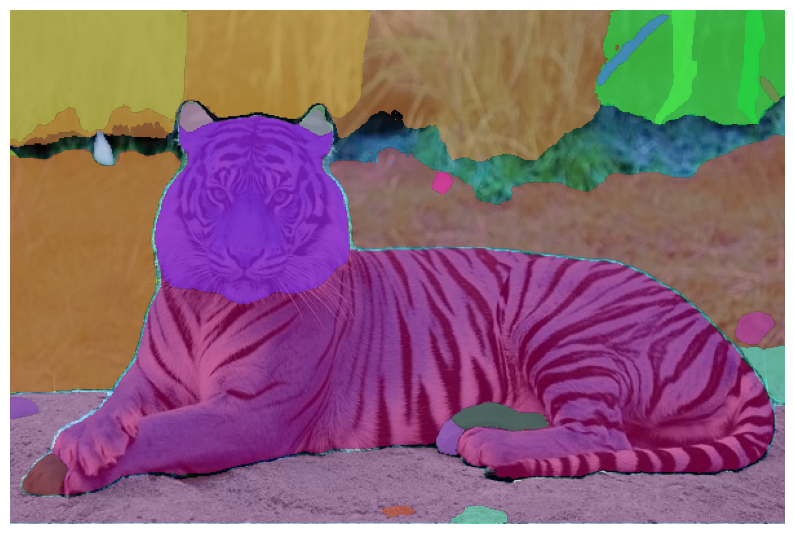

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(image)
for mask in segments:
    show_mask(mask, plt.gca(), random_color=True)
plt.axis('off')
plt.show() 